In [254]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import io
import schedule
import time
from datetime import date, timedelta
import win32com.client as win32
import teradatasql
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import telebot
import logging

In [255]:
df=pd.read_csv('tmp_ak_home_tile_nps_fbc_v2.csv')
pd.set_option('display.max_columns', 100) 
df

,subs_id,report_date,branch_id,region_nps,region_tele2,ts1m,operator,ltr,nps,nps_category,home_sector,maxdata_sector,home_lon,home_lat,maxdata_lon,maxdata_lat,home_tile,maxdata_tile,s2_cell_id_13,uniq_users_tile,first_buf_count_tech,fbc_ge_050sec,fbc_ge_075sec,fbc_ge_1sec,fbc_ge_2sec,fbc_ge_3sec,fbc_ge_4sec,fbc_ge_050sec_pc,fbc_ge_075sec_pc,fbc_ge_1sec_pc,fbc_ge_2sec_pc,fbc_ge_3sec_pc,fbc_ge_4sec_pc,pc_050sec_bad_fbc_top,pc_075sec_bad_fbc_top,pc_1sec_bad_fbc_top,pc_2sec_bad_fbc_top,pc_3sec_bad_fbc_top,pc_4sec_bad_fbc_top,gap_050sec,gap_075sec,gap_1sec,gap_2sec,gap_3sec,gap_4sec
0,44101852,01.02.2022,3.0,Ростов на Дону,Ростов-на-Дону,01.02.2022,Tele2,8.0,0,Passive,RO0461_2,RO0461_2,38.368700,47.331300,38.368700,47.331300,4675076797958717440,4675076797958717440,4675076797958717440,99,171,162,118,65,16,12,7,0.947368,0.690058,0.380117,0.093567,0.070175,0.040936,0.581031,0.344391,0.164672,0.025584,0.009022,0.004320,0.366338,0.345668,0.215445,0.067984,0.061153,0.036616
1,5319213,01.03.2022,3.0,Ростов на Дону,Ростов-на-Дону,01.03.2022,Tele2,10.0,1,Promoter,RO0458_1,RO0435_2,38.851778,47.217694,38.839472,47.186306,4675114421872230400,4675112566446358528,4675112566446358528,6648,6582,5766,4396,3033,897,433,253,0.876026,0.667882,0.460802,0.136281,0.065785,0.038438,0.539716,0.312464,0.158599,0.025131,0.009104,0.005058,0.336309,0.355418,0.302204,0.111150,0.056681,0.033380
2,6831969,01.06.2022,3.0,Ростов на Дону,Ростов-на-Дону,01.06.2022,Tele2,7.0,0,Passive,RO0416_1,RO0416_1,38.801278,47.242083,38.801278,47.242083,4675113700317724672,4675113700317724672,4675113700317724672,2392,4232,3562,2515,1685,547,269,168,0.841682,0.594282,0.398157,0.129253,0.063563,0.039698,0.558376,0.327201,0.180637,0.032861,0.011362,0.005241,0.283307,0.267081,0.217520,0.096392,0.052202,0.034457
3,68339938,01.08.2022,3.0,Ростов на Дону,Ростов-на-Дону,01.08.2022,Tele2,10.0,1,Promoter,RO0402_3,RO0454_1,38.884444,47.247694,38.874032,47.238485,4675114799829352448,4675114181354061824,4675114181354061824,37530,63809,54455,40003,27831,8905,4584,2941,0.853406,0.626918,0.436161,0.139557,0.071839,0.046091,0.561988,0.320732,0.182568,0.030085,0.011709,0.005874,0.291418,0.306186,0.253593,0.109472,0.060130,0.040217
4,66739797,01.11.2022,3.0,Ростов на Дону,Ростов-на-Дону,01.11.2022,Tele2,1.0,-1,Detractor,RO0414_1,RO0454_2,38.874333,47.232222,38.874032,47.238485,4675114559311183872,4675114181354061824,4675114181354061824,38037,73981,64733,52137,38122,12627,6223,3709,0.874995,0.704735,0.515294,0.170679,0.084116,0.050134,0.529289,0.345759,0.200501,0.040252,0.015661,0.008486,0.345706,0.358976,0.314794,0.130427,0.068455,0.041648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581046,100046896280,01.04.2023,68.0,Владивосток,Владивосток,01.04.2023,Tele2,2.0,-1,Detractor,VV0037_1,VV0080_1,132.366627,43.109271,132.347842,43.105319,6896098635482660864,6896098772921614336,6896098772921614336,3828,7862,6806,6521,6037,1148,352,172,0.865683,0.829433,0.767871,0.146019,0.044772,0.021877,0.692857,0.642451,0.578446,0.098829,0.027037,0.012556,0.172826,0.186982,0.189424,0.047190,0.017736,0.009322
581047,100071578653,01.02.2023,68.0,Владивосток,Владивосток,01.02.2023,Tele2,5.0,-1,Detractor,VV2090_1,VV0187_3,132.357271,43.097561,132.328046,43.077455,6896098738561875968,6896110455232659456,6896110455232659456,987,1978,1704,1633,1507,404,128,58,0.861476,0.825581,0.761881,0.204247,0.064712,0.029323,0.645179,0.605398,0.553484,0.121169,0.034900,0.014986,0.216297,0.220183,0.208397,0.083078,0.029812,0.014337
581048,100080686431,01.03.2023,68.0,Владивосток,Владивосток,01.03.2023,Tele2,10.0,1,Promoter,VV0073_1,VV0073_1,131.391151,42.853379,131.391151,42.853379,6896252979427409920,6896252979427409920,6896252979427409920,2268,6384,6006,5879,5611,2826,1594,1043,0.940789,0.920896,0.878916,0.442669,0.249687,0.163377,0.708110,0.663845,0.595697,0.132013,0.039119,0.016781,0.232680,0.257

In [256]:
display(df.query('first_buf_count_tech <101').first_buf_count_tech.value_counts())
display(df.query('first_buf_count_tech <101').first_buf_count_tech.value_counts().sum())

first_buf_count_tech
1     959
2     657
3     544
4     458
5     405
     ... 
97     45
98     45
92     44
81     43
84     40
Name: count, Length: 100, dtype: int64

12368

In [257]:
df_t = df.query('first_buf_count_tech >100')

In [258]:
df_t.isnull().sum().sum()

25

In [259]:
df_t.dropna(inplace = True)
df_t.isnull().sum().sum()
df_t.duplicated().sum()

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\536836101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.dropna(inplace = True)


0

In [260]:
df_t.describe()

,subs_id,branch_id,ltr,nps,home_lon,home_lat,maxdata_lon,maxdata_lat,home_tile,maxdata_tile,s2_cell_id_13,uniq_users_tile,first_buf_count_tech,fbc_ge_050sec,fbc_ge_075sec,fbc_ge_1sec,fbc_ge_2sec,fbc_ge_3sec,fbc_ge_4sec,fbc_ge_050sec_pc,fbc_ge_075sec_pc,fbc_ge_1sec_pc,fbc_ge_2sec_pc,fbc_ge_3sec_pc,fbc_ge_4sec_pc,pc_050sec_bad_fbc_top,pc_075sec_bad_fbc_top,pc_1sec_bad_fbc_top,pc_2sec_bad_fbc_top,pc_3sec_bad_fbc_top,pc_4sec_bad_fbc_top,gap_050sec,gap_075sec,gap_1sec,gap_2sec,gap_3sec,gap_4sec
count,5.686800e+05,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,5.686800e+05,5.686800e+05,5.686800e+05,5.686800e+05,5.686800e+05,5.686800e+05,5.686800e+05,5.686800e+05,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000,568680.000000
mean,1.389731e+11,46.986282,7.496422,0.248090,52.755422,54.790918,52.707701,54.792360,5.018332e+18,5.019541e+18,5.019541e+18,9.387122e+04,1.557073e+05,1.360010e+05,1.073309e+05,7.858361e+04,27325.444396,13632.438572,8101.249453,0.874105,0.690395,0.507557,0.173047,0.085179,0.050747,0.558646,0.350310,0.199545,0.032837,0.011173,0.005387,0.315459,0.340084,0.308012,0.140210,0.074006,0.045360
std,1.088035e+11,37.630357,3.172269,0.891969,23.508291,4.082493,23.469294,4.059470,5.727056e+17,5.703932e+17,5.703932e+17,1.373473e+05,2.122049e+05,1.877734e+05,1.514613e+05,1.114897e+05,39278.011701,19688.474088,11658.310610,0.056636,0.111561,0.123803,0.067214,0.039103,0.027439,0.105512,0.124620,0.102994,0.029305,0.008524,0.003636,0.083516,0.082128,0.082003,0.057127,0.036925,0.026630
min,1.583650e+05,2.000000,1.000000,-1.000000,0.000000,0.000000,19.885462,42.421700,1.152922e+18,4.675029e+18,4.675029e+18,6.000000e+00,1.010000e+02,2.300000e+01,7.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.075908,0.023102,0.006601,0.000000,0.000000,0.000000,0.320417,0.124890,0.058399,0.007570,0.002579,0.001314,-0.341607,-0.395536,-0.313955,-0.294061,-0.153285,-0.100821
25%,6.581552e+07,14.000000,5.000000,-1.000000,37.656422,52.783611,37.640947,52.778347,4.703290e+18,4.703308e+18,4.703308e+18,8.144000e+03,1.699100e+04,1.494300e+04,1.176300e+04,8.520000e+03,2701.000000,1253.000000,721.000000,0.842780,0.612903,0.423070,0.130793,0.061003,0.034969,0.509742,0.263205,0.136800,0.020445,0.006708,0.003173,0.262744,0.295069,0.263344,0.104863,0.051774,0.030391
50%,1.000731e+11,35.000000,9.000000,1.000000,41.920069,55.359472,41.848689,55.364473,4.860395e+18,4.869348e+18,4.869348e+18,4.026000e+04,7.746950e+04,6.749250e+04,5.266900e+04,3.834050e+04,13147.500000,6514.000000,3880.000000,0.884672,0.698619,0.500937,0.166032,0.080686,0.047372,0.572444,0.354375,0.187674,0.029817,0.010172,0.004951,0.312996,0.342005,0.309107,0.136072,0.070217,0.042300
75%,2.000880e+11,69.000000,10.000000,1.000000,61.287016,56.639847,61.276411,56.641333,5.086557e+18,5.086759e+18,5.086759e+18,1.259200e+05,2.080570e+05,1.794090e+05,1.400990e+05,1.024850e+05,35832.250000,17904.250000,10672.000000,0.912676,0.767998,0.577976,0.205362,0.103592,0.062244,0.625679,0.435229,0.241678,0.038170,0.013608,0.006723,0.362938,0.389261,0.355860,0.170651,0.091587,0.056369
max,3.000675e+11,177.000000,10.000000,1.000000,162.585474,71.982945,162.585474,69.561184,6.896610e+18,6.896610e+18,6.896610e+18,1.413664e+06,1.928769e+06,1.743814e+06,1.473175e+06,1.094820e+06,397448.000000,202356.000000,118198.000000,1.000000,1.000000,1.000000,0.994512,0.989572,0.974753,0.969691,0.929614,0.910824,0.591481,0.194554,0.119002,0.653702,0.792997,0.802330,0.878065,0.942553,0.956843


In [261]:
df_t.gap_1sec =  round(df_t.gap_1sec, 2)
df_t.gap_2sec =  round(df_t.gap_2sec, 2)
df_t.gap_3sec =  round(df_t.gap_3sec, 2)
df_t.gap_4sec =  round(df_t.gap_4sec, 2)

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\4144445031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.gap_1sec =  round(df_t.gap_1sec, 2)
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\4144445031.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t.gap_2sec =  round(df_t.gap_2sec, 2)
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\4144445031.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [262]:
t1 = df_t.groupby(['gap_1sec'], as_index = False).agg({'nps':'mean'})
t2 = df_t.groupby(['gap_2sec'], as_index = False).agg({'nps':'mean'})
t3 = df_t.groupby(['gap_3sec'], as_index = False).agg({'nps':'mean'})
t4 = df_t.groupby(['gap_4sec'], as_index = False).agg({'nps':'mean'})

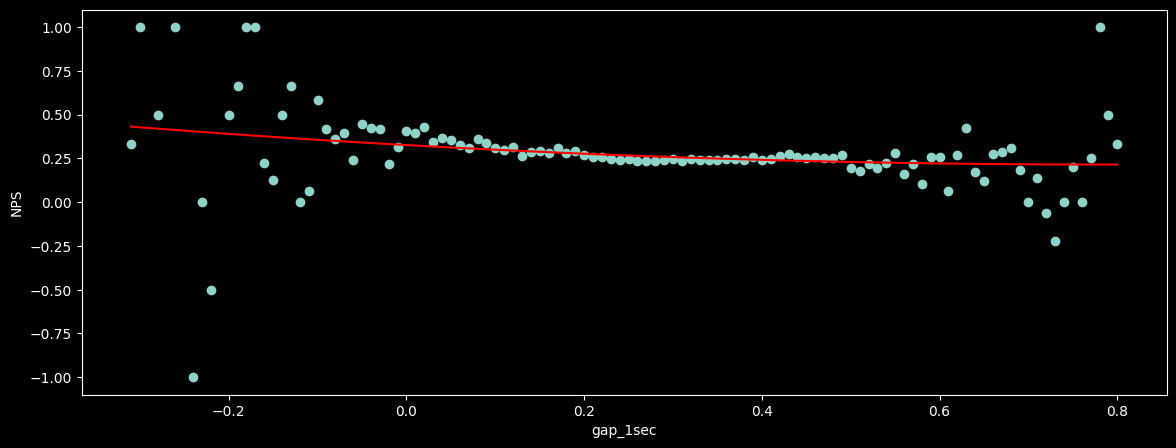

In [263]:
fig, ax = plt.subplots( figsize = (14,5) )
ax.scatter(y = t1.nps , x =t1.gap_1sec)

# Находим коэффициенты полинома второй степени
x = t1['gap_1sec']
y = t1['nps']
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

# Строим полиномиальную линию тренда
ax.plot(x, p(x), color='red')

ax.set_xlabel('gap_1sec')
ax.set_ylabel('NPS')
plt.show()

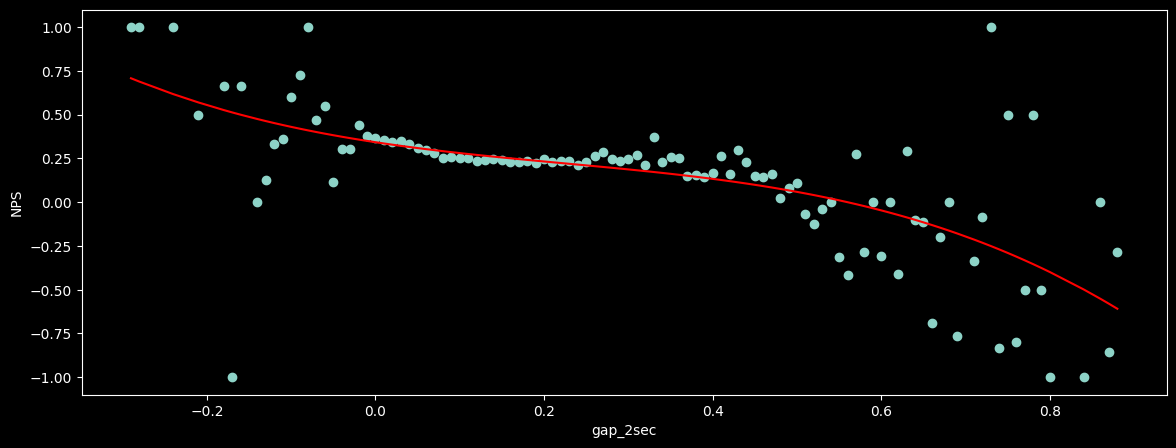

In [264]:
fig, ax = plt.subplots( figsize = (14,5) )
ax.scatter(y = t2.nps , x =t2.gap_2sec)

# Находим коэффициенты полинома второй степени
x = t2['gap_2sec']
y = t2['nps']
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

# Строим полиномиальную линию тренда
ax.plot(x, p(x), color='red')

ax.set_xlabel('gap_2sec')
ax.set_ylabel('NPS')
plt.show()

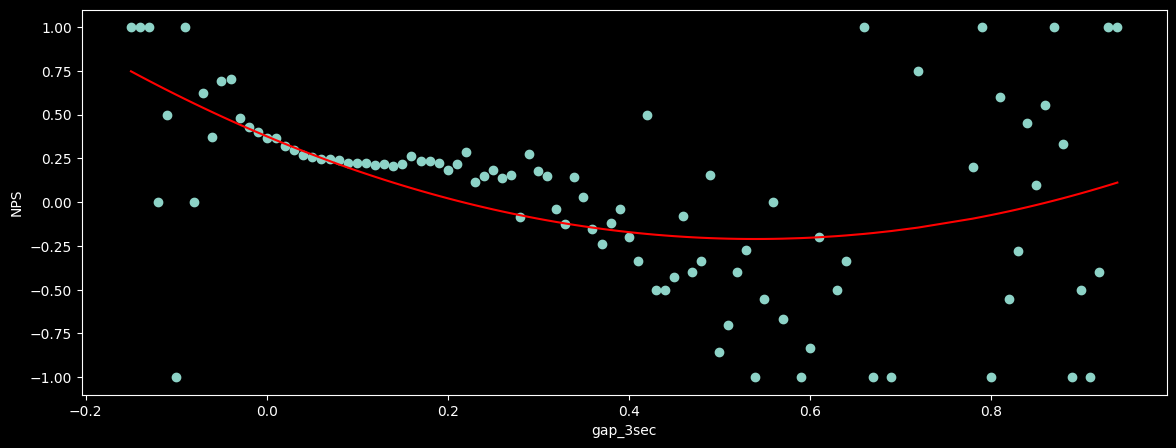

In [265]:
fig, ax = plt.subplots( figsize = (14,5) )
ax.scatter(y = t3.nps , x =t3.gap_3sec)

# Находим коэффициенты полинома второй степени
x = t3['gap_3sec']
y = t3['nps']
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

# Строим полиномиальную линию тренда
ax.plot(x, p(x), color='red')

ax.set_xlabel('gap_3sec')
ax.set_ylabel('NPS')
plt.show()

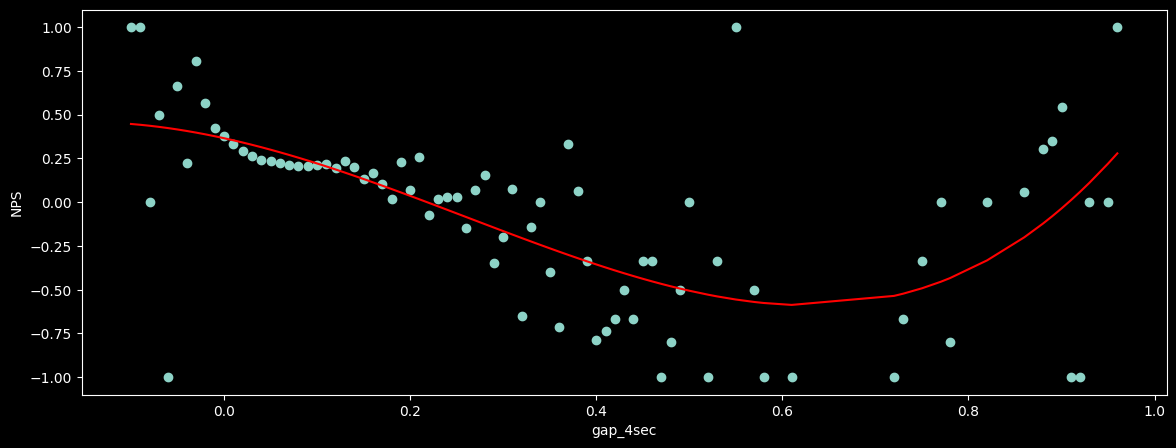

In [266]:
fig, ax = plt.subplots( figsize = (14,5) )
ax.scatter(y = t4.nps , x =t4.gap_4sec)

# Находим коэффициенты полинома второй степени
x = t4['gap_4sec']
y = t4['nps']
z = np.polyfit(x, y, 4)
p = np.poly1d(z)

# Строим полиномиальную линию тренда
ax.plot(x, p(x), color='red')

ax.set_xlabel('gap_4sec')
ax.set_ylabel('NPS')
plt.show()

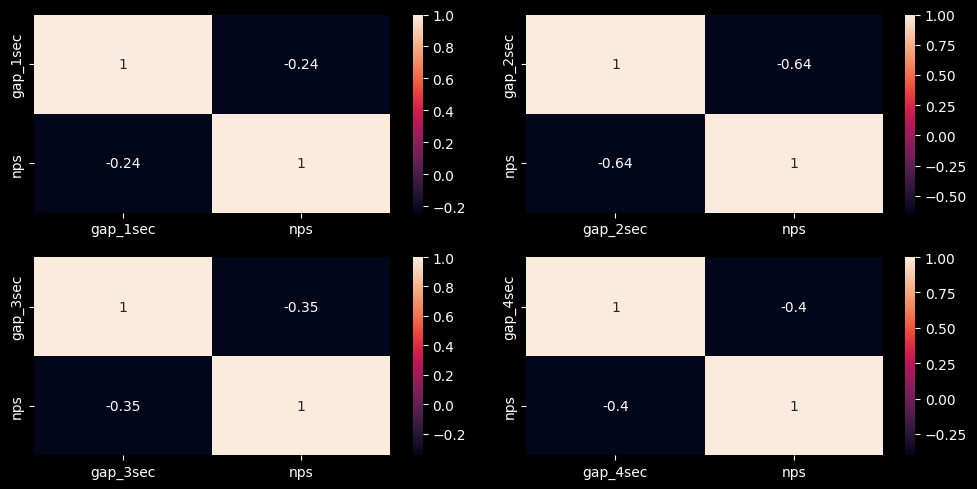

In [267]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

sns.heatmap(t1.corr(), annot=True, ax=ax1)
sns.heatmap(t2.corr(), annot=True, ax=ax2)
sns.heatmap(t3.corr(), annot=True, ax=ax3)
sns.heatmap(t4.corr(), annot=True, ax=ax4)

plt.tight_layout()
plt.show()

In [332]:
#df_t['cut1']=pd.cut(df_t['gap_1sec'], bins=10)
df_t['cut2']=pd.cut(df_t['gap_2sec'], bins=7)
#df_t['cut3']=pd.cut(df_t['gap_3sec'], bins=10)
df_t['cut4']=pd.cut(df_t['gap_4sec'], bins=7)
df_t['qcut2'] = pd.qcut(df_t['gap_2sec'], q=15, precision=0, duplicates='drop')
#df_t['cut4'] = pd.qcut(df_t['gap_4sec'], q=11, precision=0, duplicates='drop')

C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\3601548225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['cut2']=pd.cut(df_t['gap_2sec'], bins=7)
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\3601548225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t['cut4']=pd.cut(df_t['gap_4sec'], bins=7)
C:\Users\vitaly.flerin\AppData\Local\Temp\ipykernel_15740\3601548225.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Функция cut разбивает данные на интервалы с равными ширинами. Это означает, что каждый интервал будет иметь одинаковый диапазон значений. Однако, количество значений в каждом интервале может отличаться, что может привести к неравномерному распределению данных. Также важно отметить, что значения на границах интервалов включаются в интервал.

Функция qcut разбивает данные на интервалы таким образом, чтобы каждый интервал содержал примерно одинаковое количество значений. Это означает, что интервалы могут иметь разную ширину, чтобы достичь более равномерного распределения данных. 

In [333]:
display(df_t.cut2.value_counts())
display(df_t.qcut2.value_counts())
display(df_t.cut4.value_counts())

cut2
(0.0443, 0.211]     502682
(0.211, 0.379]       44959
(-0.123, 0.0443]     19138
(0.379, 0.546]        1551
(0.546, 0.713]         253
(0.713, 0.88]           72
(-0.291, -0.123]        25
Name: count, dtype: int64

qcut2
(0.08, 0.1]     66733
(0.12, 0.13]    47058
(0.11, 0.12]    46792
(0.13, 0.14]    45462
(0.1, 0.11]     42873
(0.14, 0.15]    42310
(0.18, 0.2]     39915
(0.15, 0.16]    39308
(-0.3, 0.06]    38759
(0.06, 0.08]    37279
(0.22, 0.88]    36353
(0.16, 0.17]    33796
(0.17, 0.18]    28287
(0.2, 0.22]     23755
Name: count, dtype: int64

cut4
(-0.101, 0.0514]    415457
(0.0514, 0.203]     152442
(0.203, 0.354]         530
(0.354, 0.506]         122
(0.809, 0.96]           93
(0.657, 0.809]          19
(0.506, 0.657]          17
Name: count, dtype: int64

In [334]:
t4 = df_t.groupby(['cut4'], as_index= False).agg({'nps': 'mean'})
t2 = df_t.groupby(['cut2'], as_index= False).agg({'nps': 'mean'})
t2q = df_t.groupby(['qcut2'], as_index= False).agg({'nps': 'mean'})

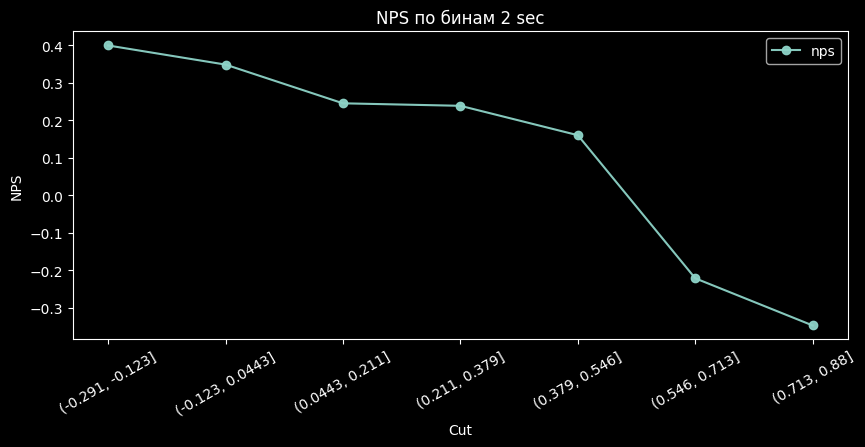

In [330]:
# создаем DataFrame из таблицы данных
#df = pd.DataFrame({'intervals': ['(-0.291, -0.212]', '(-0.212, -0.134]', '(-0.134, -0.056]', '(-0.056, 0.022]', 
#                                '(0.022, 0.1]', '(0.1, 0.178]', '(0.178, 0.256]', '(0.256, 0.334]', 
#                               '(0.334, 0.412]', '(0.412, 0.49]', '(0.49, 0.568]', '(0.568, 0.646]', 
#                               '(0.646, 0.724]', '(0.724, 0.802]', '(0.802, 0.88]'],
#                      'values': [1.000000, 0.333333, 0.506024, 0.357574, 0.271510, 0.240676, 0.232330, 0.262732, 
#                                0.210673, 0.183121, -0.073684, -0.112583, -0.348837, -0.317073, -0.578947]})
# создаем график
t2.plot(x='cut2', y='nps', kind='line', marker='o', figsize = (10,4), alpha=0.95)
# задаем метки оси x и угол поворота
plt.xticks(ticks=t2.index, labels=t2['cut2'], rotation=30)
# задаем подписи осей и заголовок графика
plt.xlabel('Cut')
plt.ylabel('NPS')
plt.title('NPS по бинам 2 sec')

# выводим график на экран
plt.show()

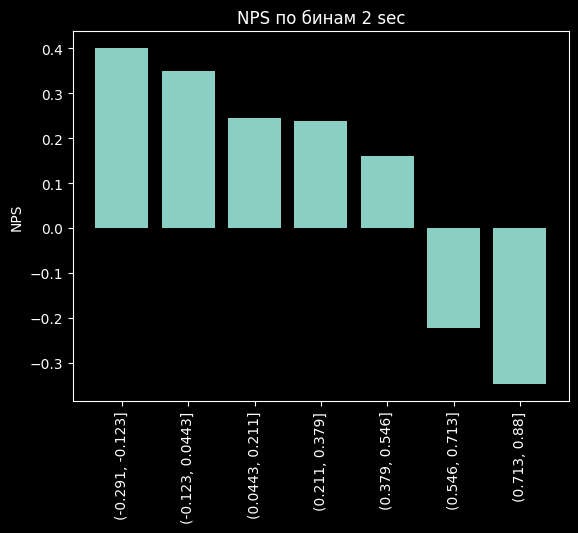

In [338]:
cuts = t2.cut2 #['(-0.291, -0.173]', '(-0.173, -0.056]', '(-0.056, 0.061]', '(0.061, 0.178]', '(0.178, 0.295]', '(0.295, 0.412]', '(0.412, 0.529]', '(0.529, 0.646]', '(0.646, 0.763]', '(0.763, 0.88]']

nps = t2.nps#[0.800000, 0.477778, 0.324711, 0.245314, 0.234807, 0.245672, 0.154696, -0.114286,  -0.355932, -0.428571]

x_pos = np.arange(len(cuts))
plt.bar(x_pos, nps, align='center', alpha=0.99)
plt.xticks(x_pos, cuts, rotation=90)
plt.ylabel('NPS')
plt.title('NPS по бинам 2 sec')
plt.show()

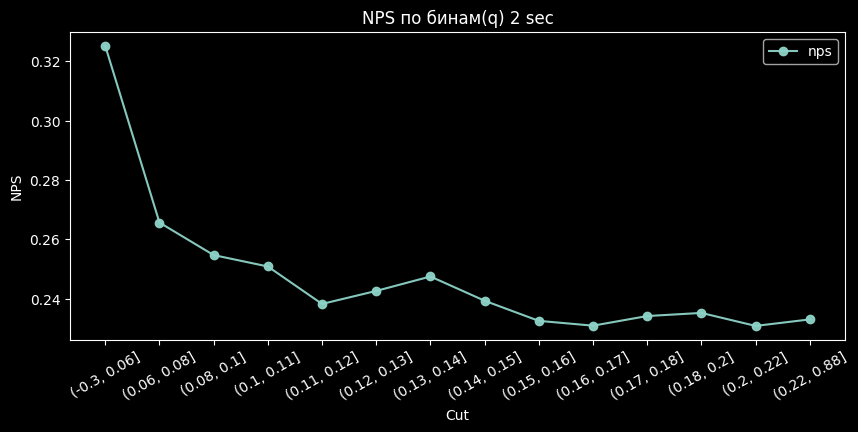

In [337]:
t2q.plot(x='qcut2', y='nps', kind='line', marker='o', figsize = (10,4), alpha=0.95)
# задаем метки оси x и угол поворота
plt.xticks(ticks=t2q.index, labels=t2q['qcut2'], rotation=30)
# задаем подписи осей и заголовок графика
plt.xlabel('Cut')
plt.ylabel('NPS')
plt.title('NPS по бинам(q) 2 sec')

# выводим график на экран
plt.show()